# Contextual linear bandit with Thompson sampling

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## Context-free multi-armed Bernoulli bandit

In [4]:
from jax.scipy.stats import beta
from jax import random
from jax.nn import one_hot

In [27]:
def bandit_step(state, key):
    alphas, betas, probs = state
    keys = key
    K = len(alphas)
    
    # Choose an arm to pull
    # (Sample from the policy distribution)
    theta_t = random.beta(key, alphas, betas).argmax()
    # Pull the arm and observe reward (either 1 or 0)
    reward = random.bernoulli(key, probs[theta_t])
    
    # Update policy distribution
    ind_vector = one_hot(theta_t, K)
    alphas_posterior = alphas + ind_vector * reward
    betas_posterior = betas + ind_vector * (1 - reward)
    
    return (alphas_posterior, betas_posterior, probs), (alphas_posterior, betas_posterior)

In [28]:
T = 200
key = random.PRNGKey(314)
keys = random.split(key, T)
probs = jnp.array([0.65, 0.4, 0.5, 0.9])
#probs = jnp.ones(5) * 0.5
K = len(probs)


alpha_priors = jnp.ones(K) * 1
beta_priors = jnp.ones(K) * 1

init_state = (alpha_priors, beta_priors, probs)
posteriors, hist = jax.lax.scan(bandit_step, init_state, keys)
alpha_posterior, beta_posterior, _ = posteriors
alpha_hist, beta_hist = hist

alpha_posterior, beta_posterior

(DeviceArray([  8.,   9.,  18., 140.], dtype=float32),
 DeviceArray([ 4.,  7., 11., 11.], dtype=float32))

In [29]:
p_range = jnp.linspace(0, 1, 100)
bandits_pdf_hist = beta.pdf(p_range[:, None, None], alpha_hist[None, ...], beta_hist[None, ...])

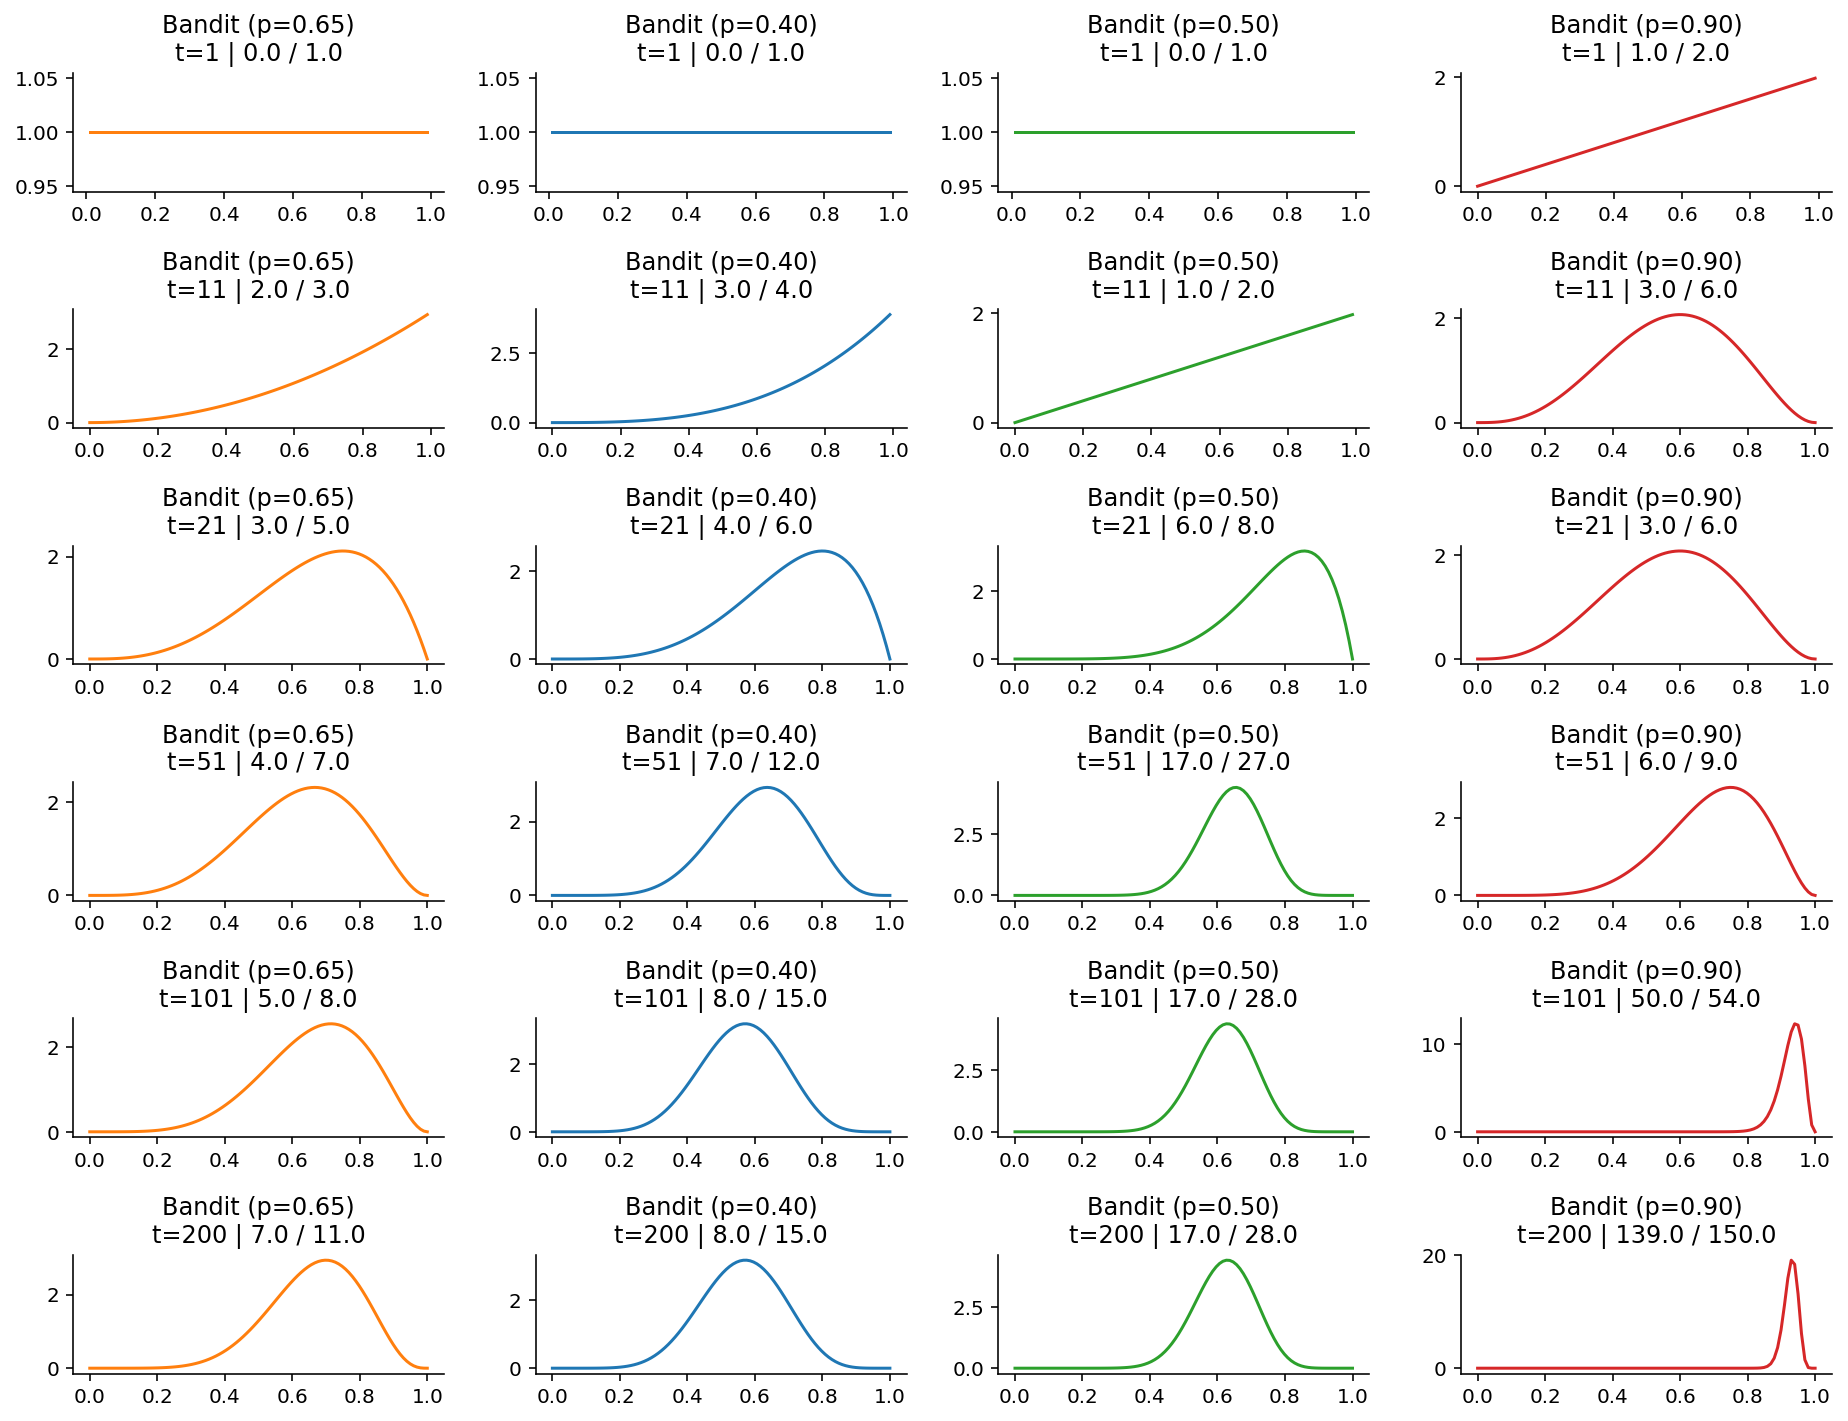

In [46]:
colors = ["orange", "blue", "green", "red", "brown"]
colors = [f"tab:{color}" for color in colors]
times = [0, 10, 20, 50, 100, 199]

fig, ax = plt.subplots(len(times), K, figsize=(13, 10))
for ax_row, t in zip(ax, times):
    for k, (axi, color) in enumerate(zip(ax_row, colors)):
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos
        axi.set_title(f"Bandit (p={probs[k]:0.2f})\nt={t+1} | {n_pos} / {n_trials}")
plt.tight_layout()

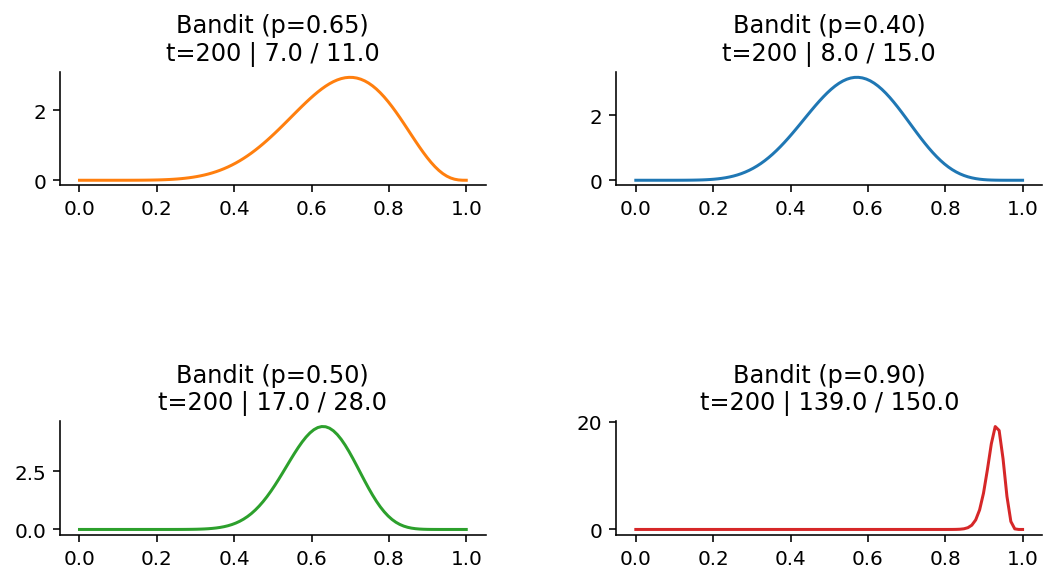

In [63]:
import matplotlib.animation as animation

fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax = ax.ravel()
def func(t):
    for k, (axi, color) in enumerate(zip(ax, colors)):
        axi.cla()
        bandit = bandits_pdf_hist[:, t, k]
        axi.plot(p_range, bandit, c=color)
        n_pos = alpha_hist[t, k].item() - 1
        n_trials = beta_hist[t, k].item() + n_pos
        axi.set_title(f"Bandit (p={probs[k]:0.2f})\nt={t+1} | {n_pos} / {n_trials}")
        plt.tight_layout()
    return ax

ani = animation.FuncAnimation(fig, func, frames=T)
ani.save("bandit_hist.mp4", dpi=200, bitrate=-1, fps=10)

## Contextual multiarmed-bandit